In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

/home/gustavolamonica/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data=pd.read_csv('ETH_1H.csv',parse_dates=['Date'],index_col=['Date']).drop(columns=['Unix Timestamp','Symbol'])

In [3]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-04-16 00:00:00,152.94,152.94,150.39,150.39,650.188125
2020-04-15 23:00:00,155.81,155.81,151.39,152.94,4277.567299
2020-04-15 22:00:00,157.18,157.30,155.32,155.81,106.337279
2020-04-15 21:00:00,158.04,158.31,157.16,157.18,55.244131
2020-04-15 20:00:00,157.10,158.10,156.87,158.04,144.262622


In [4]:
data=data.sort_index()

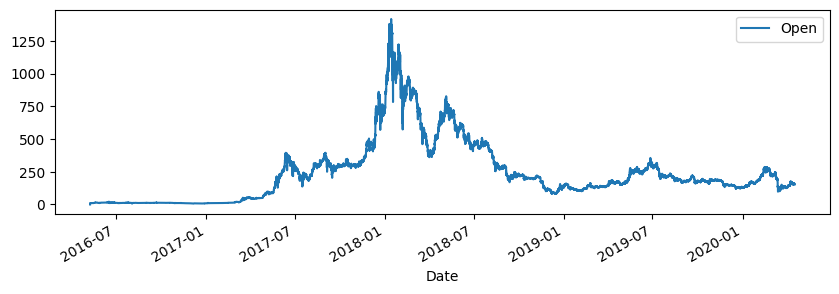

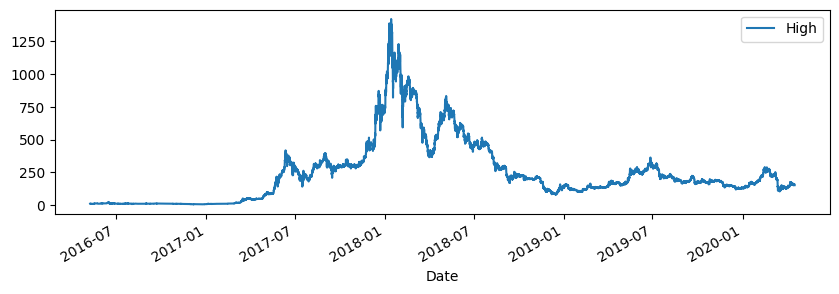

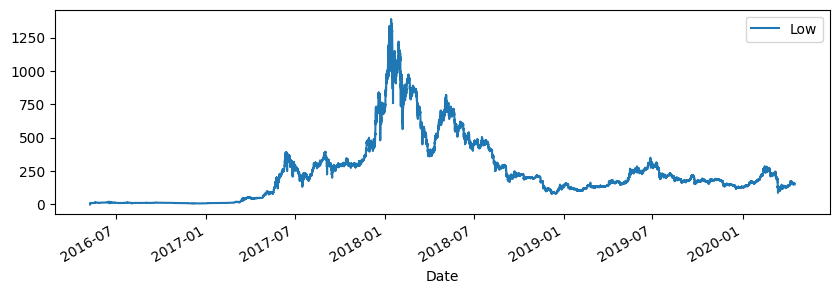

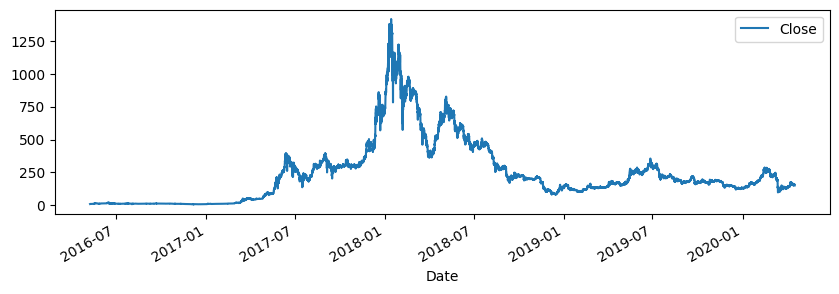

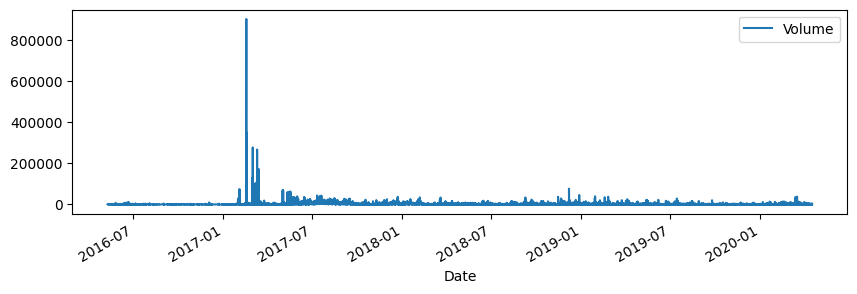

In [5]:
for i in data:
    plt.figure(figsize=(10,3))
    data[i].plot(legend=i)
    plt.show()

In [6]:
data.duplicated().sum()

1851

In [7]:
data.index.duplicated().sum()

0

In [8]:
data.shape

(34497, 5)

In [9]:
data.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [10]:
def create_f(df):
    df=df.copy()
    df['hour']=df.index.hour
    df['day']=df.index.day
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayofweek']=df.index.dayofweek
    df['dayofyear']=df.index.dayofyear
    df['weekofyear']=df.index.isocalendar().week
    return df

In [11]:
df=create_f(data)

In [12]:
df.head()

,Open,High,Low,Close,Volume,hour,day,month,year,dayofweek,dayofyear,weekofyear
Date,,,,,,,,,,,,
2016-05-09 13:00:00,0.00,12.00,0.00,9.55,432.562115,13,9,5,2016,0,130,19
2016-05-09 14:00:00,9.55,10.00,9.55,10.00,235.774075,14,9,5,2016,0,130,19
2016-05-09 15:00:00,10.00,10.00,9.99,9.99,10.973567,15,9,5,2016,0,130,19
2016-05-09 16:00:00,9.99,9.99,9.79,9.83,62.379450,16,9,5,2016,0,130,19
2016-05-09 17:00:00,9.83,9.83,9.48,9.49,329.553213,17,9,5,2016,0,130,19


In [13]:
#generating windows
# 24 hour window to predict 25th hour using only close

close= df.iloc[:,3]
windows=[]
target=[]
length=240
for i in (range(len(close)-length)):
    x= close.iloc[i:i+length]
    y=close.iloc[i+length]
    windows.append(x)
    target.append(y)

windows=np.array(windows)
target=np.array(target).reshape(-1,1)

In [14]:
#creating train and test data
from sklearn.preprocessing import MinMaxScaler


sc=MinMaxScaler()
windows_sc=sc.fit_transform(windows)
target_sc=sc.fit_transform(target)

windows_sc=windows_sc.reshape((len(windows_sc),length,1))

In [15]:
#splitting

split= int(0.8*len(windows_sc))

X_train=windows_sc[:split,:,:]
X_test=windows_sc[split:,:,:]
y_train=target_sc[:split,:]
y_test=target_sc[split:,:]

In [16]:
print(X_train.shape,y_train.shape)

(27405, 240, 1) (27405, 1)


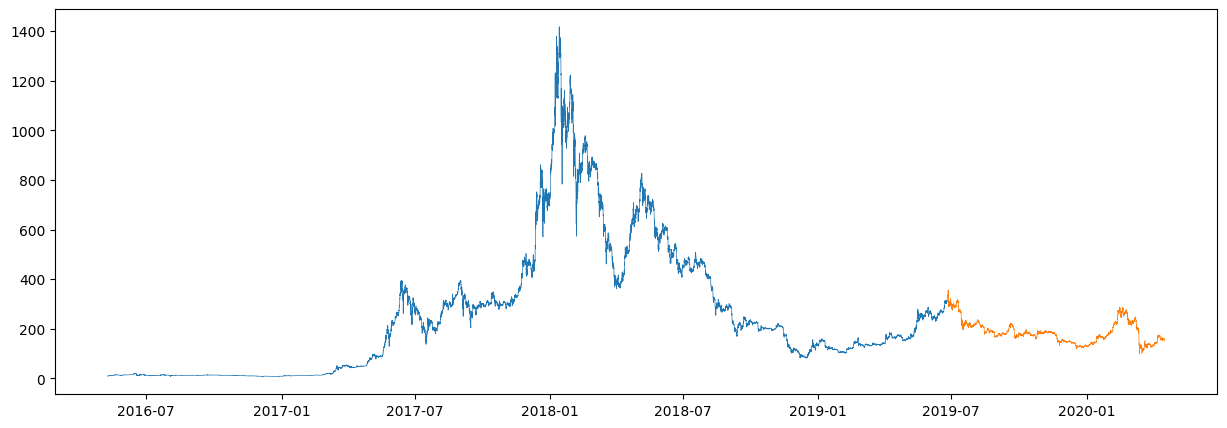

In [17]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'][:split],label='Train',linewidth=0.5)
plt.plot(df['Close'][split:],label='Test',linewidth=0.5)

In [18]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from sklearn.metrics import *

2024-07-23 20:58:55.015144: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 20:58:55.031764: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 20:58:55.159095: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 20:58:55.268294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 20:58:55.377054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [19]:
model=Sequential()
model.add(LSTM(100,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1,activation='linear'))

model.compile(optimizer='adam',loss='mse')

/home/gustavolamonica/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.fit(X_train,y_train,epochs=5,batch_size=64,verbose=1)

Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 56s 128ms/step - loss: 0.0016
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 60s 141ms/step - loss: 2.4966e-04
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 62s 144ms/step - loss: 2.1394e-04
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 64s 149ms/step - loss: 1.8048e-04
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 63s 146ms/step - loss: 1.6823e-04


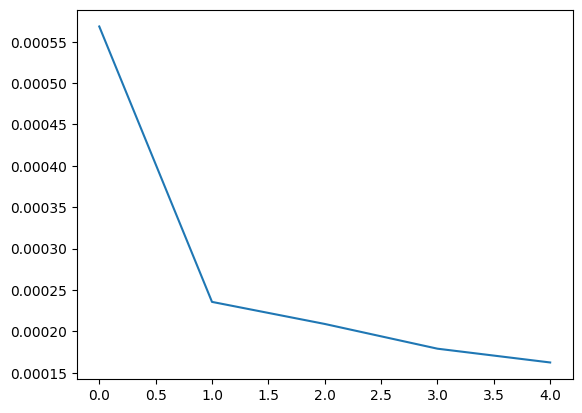

In [22]:
plt.plot(model.history.history['loss'])

In [23]:
pred_sc=model.predict(X_test)
pred=sc.inverse_transform(pred_sc)
y_test_ic=sc.inverse_transform(y_test)

215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step


The coefficent of determination (R-squared) = 0.994


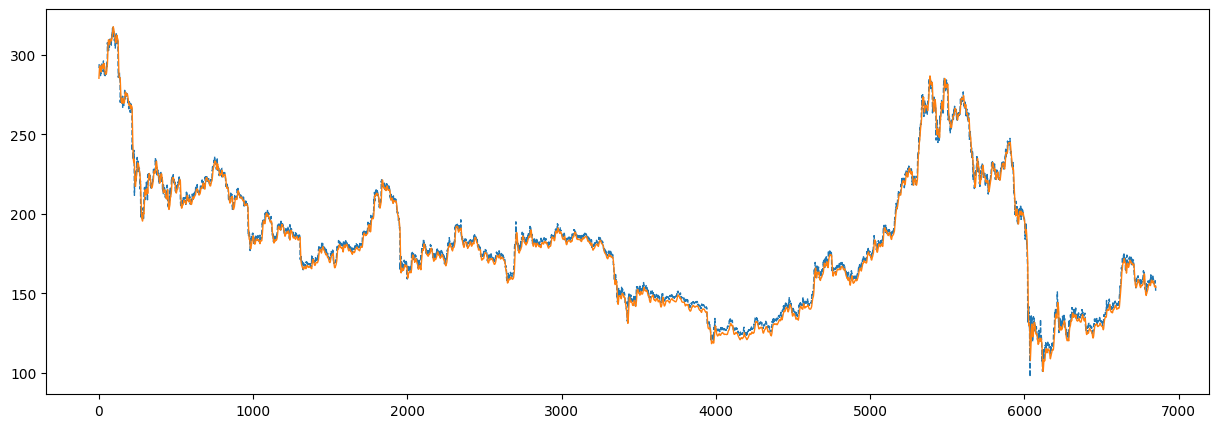

In [24]:
print('The coefficent of determination (R-squared) = {:.3f}'.format(r2_score(pred,y_test_ic)))

plt.figure(figsize=(15,5))
plt.plot(y_test_ic,'--',label='Actual',linewidth=1)
plt.plot(pred,label='Predicted',linewidth=1)

In [25]:
model2=Sequential()
model2.add(LSTM(100,input_shape=(X_train.shape[1],X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='linear'))

model2.compile(optimizer='adam',loss='mse')

/home/gustavolamonica/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
#training on entire dataset

X=windows_sc
y=target_sc

model2.fit(X,y,epochs=5,batch_size=64,verbose=1)

Epoch 1/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 80s 147ms/step - loss: 0.0030
Epoch 2/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 79s 147ms/step - loss: 2.1022e-04
Epoch 3/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 80s 149ms/step - loss: 1.9201e-04
Epoch 4/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 81s 150ms/step - loss: 1.4387e-04
Epoch 5/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 79s 147ms/step - loss: 1.4131e-04
